# Part1
## Import KMNIST

In [2]:
# import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)


>  1


Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)


>  2


100%|████████████████████████████████████| 17954/17954 [00:20<00:00, 882.24KB/s]


100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 77.82KB/s]


100%|██████████████████████████████████████| 3008/3008 [00:04<00:00, 683.74KB/s]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5687.19KB/s]

All dataset files downloaded!


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
from tensorflow.keras.optimizers import Adam
import pandas as pd
import time

def set_seed(seed=42):
    """Ensure reproducibility by setting random seeds."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seed(42)

# Function to measure execution time of each step
def log_time(step_name, start_time):
    end_time = time.time()
    print(f"{step_name} completed in {end_time - start_time:.2f} seconds.")
    return end_time

## Divide KMNIST

In [5]:
# Load the Kuzushiji-MNIST data
train_images = np.load('kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_images = np.load('kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten the images for input into the Stacked Autoencoder
train_images_flattened = train_images.reshape(-1, 784)
test_images_flattened = test_images.reshape(-1, 784)

x_test = test_images_flattened
y_test = test_labels

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_images_flattened, train_labels, test_size=0.2, random_state=42)

In [6]:
def build_sae(bottleneck_size=64):
    # Encoder
    input_layer = Input(shape=(784,))
    encoder = Dense(800, activation='relu')(input_layer)
    encoder = Dense(200, activation='relu')(encoder)
    bottleneck = Dense(bottleneck_size, activation='relu')(encoder)

    # Decoder
    decoder = Dense(200, activation='relu')(bottleneck)
    decoder = Dense(800, activation='relu')(decoder)
    output_layer = Dense(784, activation='sigmoid')(decoder)

    # Build model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder


In [7]:

def extract_features(autoencoder, data):

    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)
    features = encoder_model.predict(data)
    return features

## Grid search SAE hyperparameters

Training SAE with bottleneck size 32, batch size 64, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
Bottleneck size 32, Batch size 64, Patience 5 - CV Accuracy: 0.9614

Training time completed in 156.35 seconds.
Training SAE with bottleneck size 32, batch size 64, patience 10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
Bottleneck size 32, Batch size 64, Patience 10 - CV Accuracy: 0.9624

Training time completed in 255.13 seconds.
Training SAE with bottleneck size 32, batch size 128, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
Bottleneck size 32, Batch size 128, Patience 5 - CV Accuracy: 0.9549

Training time completed in 111.27 seconds.
Training SAE with bottleneck size 32, batch size 128, patience 10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
Bottleneck size 32, Batch size 128, Patience 10 - 

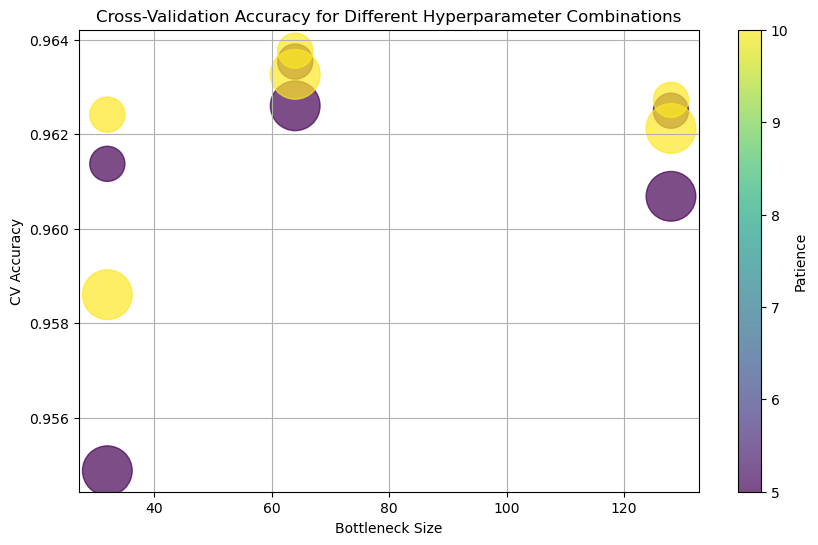

In [9]:
from itertools import product

# Define ranges for hyperparameters to test
bottleneck_sizes = [32, 64, 128]
batch_sizes = [64, 128]
patience_values = [5, 10]

cv_results = {}

for bottleneck_size, batch_size, patience in product(bottleneck_sizes, batch_sizes, patience_values):
    print(f"Training SAE with bottleneck size {bottleneck_size}, batch size {batch_size}, patience {patience}")
    time_sae_grid = time.time()

    # Build the autoencoder
    autoencoder = build_sae(bottleneck_size)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the autoencoder with early stopping
    autoencoder.fit(
        x_train, x_train,
        epochs=50,  # Set a high epoch limit, early stopping will determine the actual stopping point
        batch_size=batch_size,
        validation_data=(x_val, x_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    val_features = extract_features(autoencoder, x_val)

    # Scale the features for the SVM classifier
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # Train an SVM classifier using cross-validation
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    scores = cross_val_score(svm_classifier, train_features_scaled, y_train, cv=5)
    avg_accuracy = np.mean(scores)

    # Store the results
    cv_results[(bottleneck_size, batch_size, patience)] = avg_accuracy
    print(f"Bottleneck size {bottleneck_size}, Batch size {batch_size}, Patience {patience} - CV Accuracy: {avg_accuracy:.4f}\n")
    log_time("Training time", time_sae_grid)


best_params = max(cv_results, key=cv_results.get)
best_accuracy = cv_results[best_params]
print(f"\nBest parameters: Bottleneck size = {best_params[0]}, Batch size = {best_params[1]}, Patience = {best_params[2]}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")



# Plot the cross-validation results
bottleneck_sizes_plot, batch_sizes_plot, patience_plot, accuracies = zip(*[(k[0], k[1], k[2], v) for k, v in cv_results.items()])
plt.figure(figsize=(10, 6))
plt.scatter(bottleneck_sizes_plot, accuracies, c=patience_plot, cmap='viridis', s=[10 * b for b in batch_sizes_plot], alpha=0.7)
plt.colorbar(label='Patience')
plt.title('Cross-Validation Accuracy for Different Hyperparameter Combinations')
plt.xlabel('Bottleneck Size')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()


#### Best SAE+SVM(batchsize = 64, bottleneck = 64)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0754 - val_loss: 0.0314
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0291 - val_loss: 0.0244
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0232 - val_loss: 0.0216
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0207 - val_loss: 0.0206
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0181 - val_loss: 0.0185
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0174 - val_loss: 0.0183
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0169 - val_loss: 0.0182
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0165 - val_loss: 0.0177
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0164 - val_loss: 0.0178
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0160 - val_loss: 0.0173
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

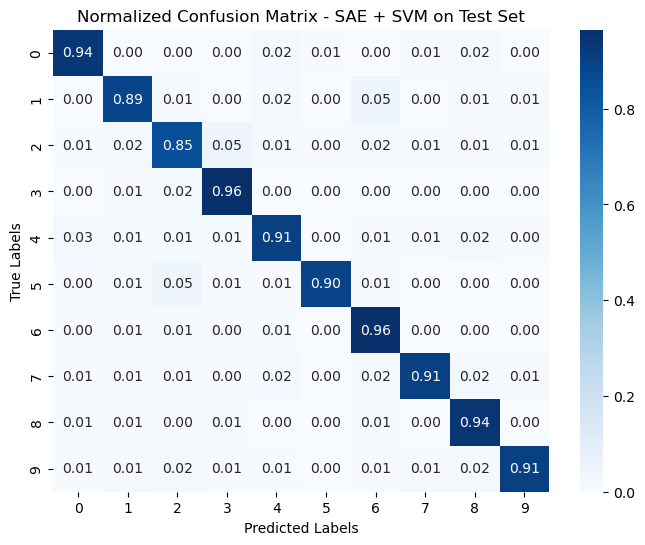

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

time_train_saesvm = time.time()

# Build and compile the autoencoder
autoencoder = build_sae(64)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train on the entire training set
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)

# Step 2: Extract Bottleneck Features
train_features = extract_features(autoencoder, x_train)
test_features = extract_features(autoencoder, x_test)

# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Step 4: Train the SVM Classifier on the Extracted Features
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(train_features_scaled, y_train)

# Step 5: Evaluate on the Test Set
test_predictions = svm_classifier.predict(test_features_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nSAE + SVM Test Accuracy: {test_accuracy:.4f}")
log_time("Train SAE+SVM time", time_train_saesvm)

# Step 6: Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [12]:
sae_total_params = autoencoder.count_params()
print(f"Total parameters in SAE model: {sae_total_params}")

Total parameters in SAE model: 1602848


## Performance w.r.t bottleneck

Training SAE with bottleneck size 16
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


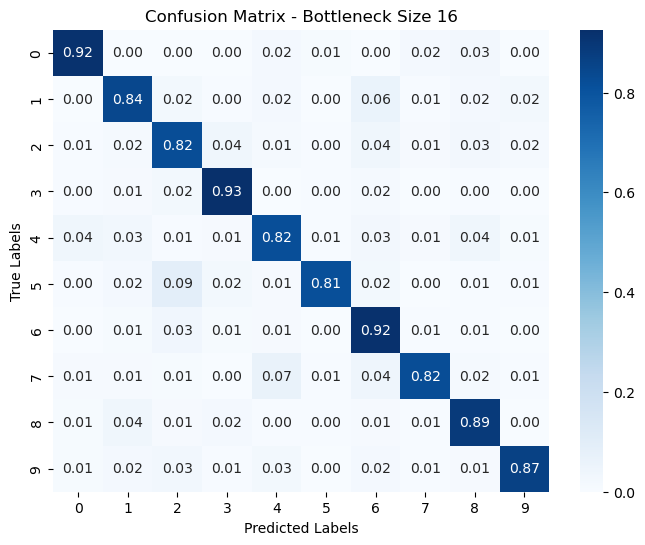

Bottleneck size 16 - Test Accuracy: 0.8641
Train time completed in 212.31 seconds.
Training SAE with bottleneck size 32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


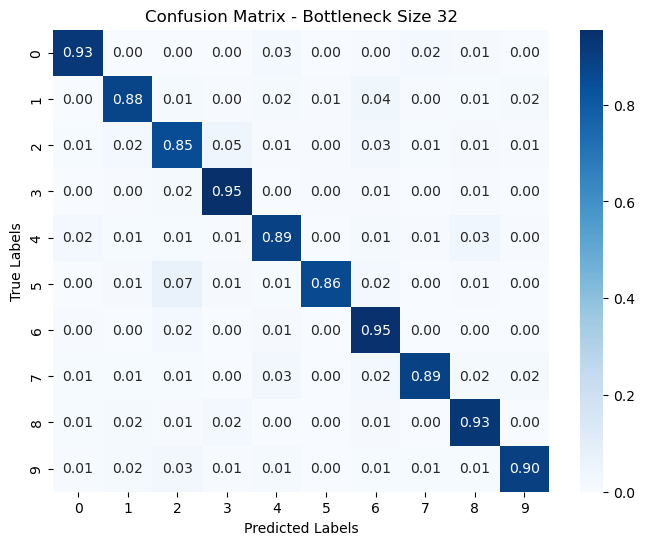

Bottleneck size 32 - Test Accuracy: 0.9029
Train time completed in 207.19 seconds.
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


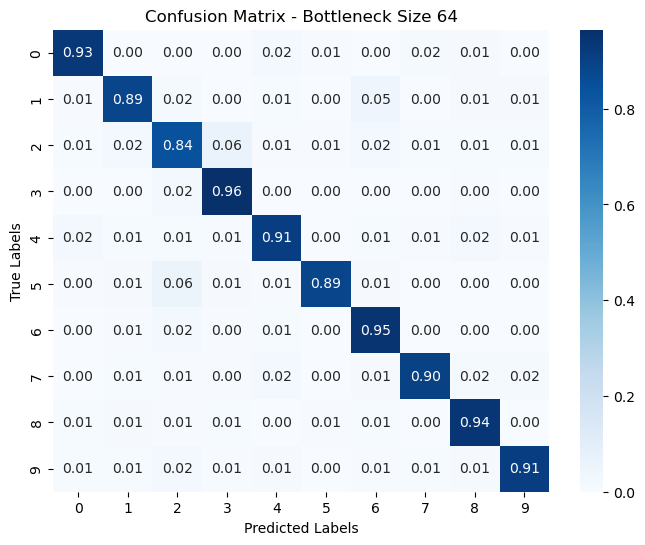

Bottleneck size 64 - Test Accuracy: 0.9135
Train time completed in 220.10 seconds.
Training SAE with bottleneck size 128
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


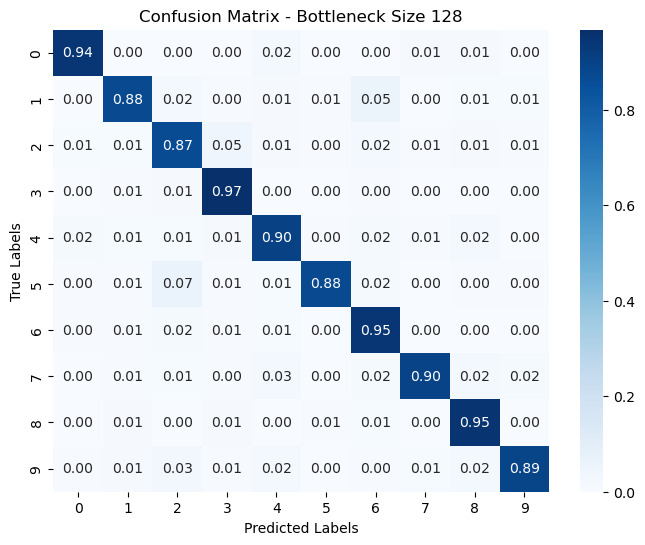

Bottleneck size 128 - Test Accuracy: 0.9122
Train time completed in 272.46 seconds.
Training SAE with bottleneck size 256
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


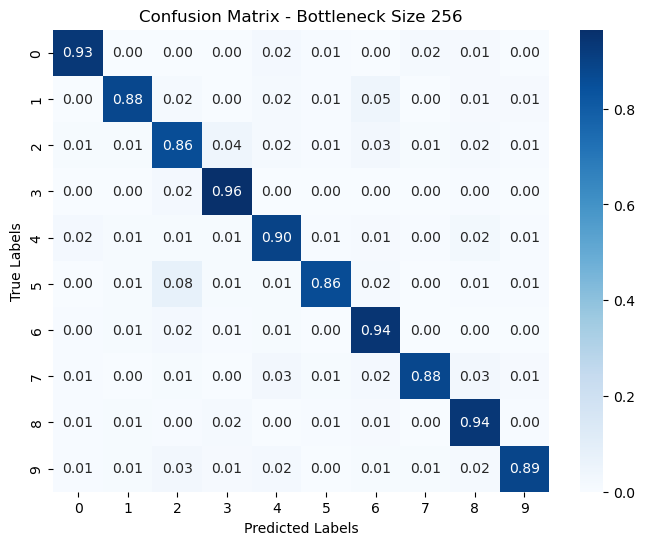

Bottleneck size 256 - Test Accuracy: 0.9038
Train time completed in 334.31 seconds.
Training SAE with bottleneck size 400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 617us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


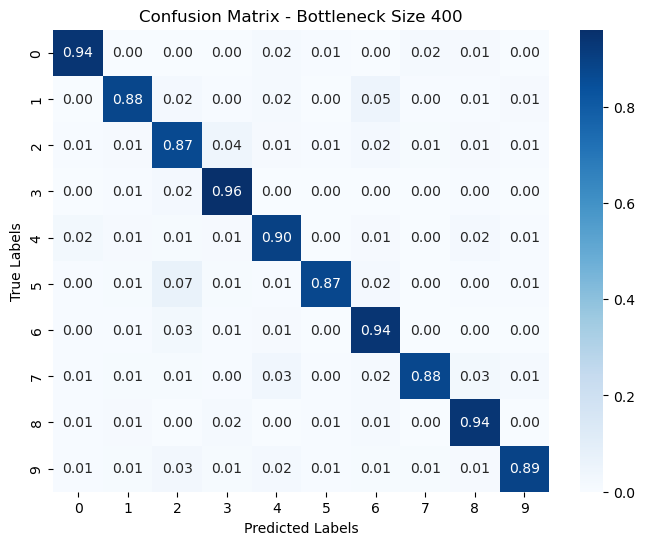

Bottleneck size 400 - Test Accuracy: 0.9065
Train time completed in 432.28 seconds.


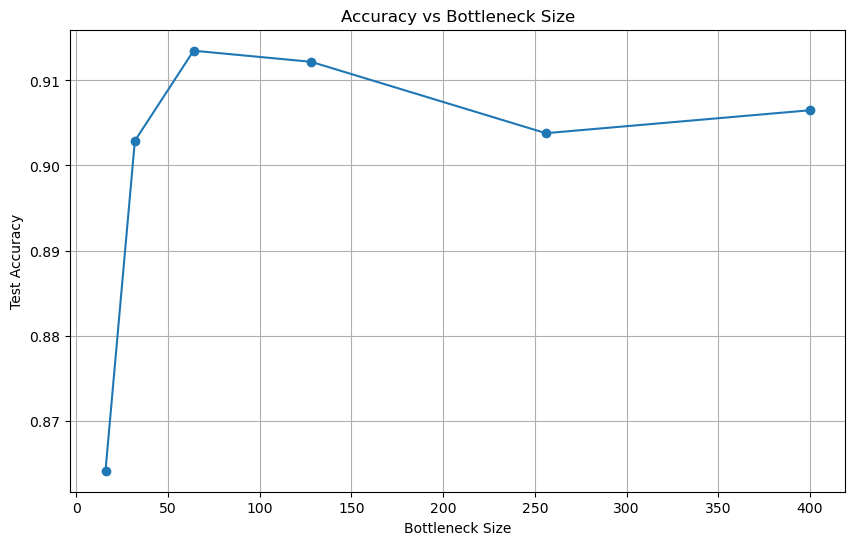

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np


def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Define bottleneck sizes to evaluate
bottleneck_sizes = [16, 32, 64, 128, 256, 400]
accuracies = []

for size in bottleneck_sizes:
    time_train_saesvm_bottleneck = time.time()
    print(f"Training SAE with bottleneck size {size}")

    # Train the SAE with current bottleneck size
    autoencoder = build_sae(size)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=64, validation_data=(x_val, x_val), verbose=0)

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    test_features = extract_features(autoencoder, x_test)

    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Train the SVM on the extracted features
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_classifier.fit(train_features_scaled, y_train)

    # Predict on the test set
    test_predictions = svm_classifier.predict(test_features_scaled)
    accuracy = accuracy_score(y_test, test_predictions)
    accuracies.append(accuracy)

    # Plot the confusion matrix for the current bottleneck size
    plot_confusion_matrix(y_test, test_predictions, f"Confusion Matrix - Bottleneck Size {size}")
    print(f"Bottleneck size {size} - Test Accuracy: {accuracy:.4f}")
    log_time("Train time", time_train_saesvm_bottleneck)

# Plot the bottleneck size vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(bottleneck_sizes, accuracies, marker='o')
plt.title("Accuracy vs Bottleneck Size")
plt.xlabel("Bottleneck Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Augmented SAE+SVM

Epoch 1/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0743 - val_loss: 0.0311
Epoch 2/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0291 - val_loss: 0.0247
Epoch 3/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0232 - val_loss: 0.0218
Epoch 4/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0203 - val_loss: 0.0201
Epoch 5/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 6/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 7/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0170 - val_loss: 0.0182
Epoch 8/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0163 - val_loss: 0.0183
Epoch 9/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0161 - val_loss: 0.0183
Epoch 10/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0159 - val_loss: 0.0177
Epoch 11/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0152 - val_loss: 0.0168
Epoch 12/50
763/763 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

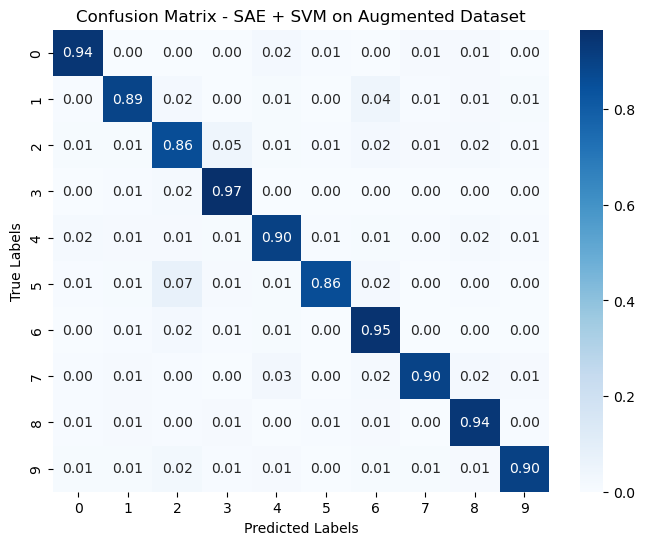

Test Accuracy: 0.9109


In [63]:
def generate_noisy_images(images, labels, noise_std=0.2, num_per_class=100):
    unique_classes = np.unique(labels)
    noisy_images = []
    noisy_labels = []

    # Generate noisy versions
    for cls in unique_classes:
        # Get all indices for the current class
        class_indices = np.where(labels == cls)[0]

        # Ensure we don't exceed the number of available samples for the class
        num_samples = min(num_per_class, len(class_indices))
        selected_indices = np.random.choice(class_indices, size=num_samples, replace=False)

        for idx in selected_indices:
            original_image = images[idx]
            noise = np.random.normal(0, noise_std, original_image.shape)
            noisy_image = np.clip(original_image + noise, 0, 1)  # Ensure pixel values are in [0, 1]
            noisy_images.append(noisy_image)
            noisy_labels.append(cls)

    return np.array(noisy_images), np.array(noisy_labels)

# Generate new noisy dataset
noisy_images, noisy_labels = generate_noisy_images(train_images, train_labels)

# Flatten noisy images for training
noisy_images_flattened = noisy_images.reshape(-1, 784)

# Combine with the original dataset
augmented_train_images = np.concatenate([train_images_flattened, noisy_images_flattened])
augmented_train_labels = np.concatenate([train_labels, noisy_labels])

# Split augmented data into training and validation sets
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(
    augmented_train_images, augmented_train_labels, test_size=0.2, random_state=42
)

# Retrain SAE model with augmented dataset
time_aug_sae = time.time()
autoencoder = build_sae(64)
autoencoder.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder.fit(
    x_train_aug, x_train_aug,
    epochs=50,
    batch_size=64,
    validation_data=(x_val_aug, x_val_aug),
    callbacks=[early_stopping],
    verbose=1
)

# Extract features
train_features_aug = extract_features(autoencoder, x_train_aug)
test_features_aug = extract_features(autoencoder, x_test)

# Scale features
scaler = StandardScaler()
train_features_scaled_aug = scaler.fit_transform(train_features_aug)
test_features_scaled_aug = scaler.transform(test_features_aug)

# Train SVM on the augmented features
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(train_features_scaled_aug, y_train_aug)
log_time("Training time on SAE+augmentation", time_aug_sae)

# Evaluate on the test set
test_predictions_aug = svm_classifier.predict(test_features_scaled_aug)

# Ensure y_test is in label format, not one-hot encoded
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check if y_test is one-hot
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

accuracy = accuracy_score(y_test_labels, test_predictions_aug)
accuracies.append(accuracy)

# Plot confusion matrix
plot_confusion_matrix(y_test_labels, test_predictions_aug, "Confusion Matrix - SAE + SVM on Augmented Dataset")
print(f"Test Accuracy: {accuracy:.4f}")


In [65]:
aug_sae_total_params = autoencoder.count_params()
print(f"Total parameters in augmented SAE model: {aug_sae_total_params}")

Total parameters in augmented SAE model: 1602848


## Augmented MLP

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1037 - loss: 2.3309 - val_accuracy: 0.2090 - val_loss: 2.1696
Epoch 2/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2672 - loss: 1.8842 - val_accuracy: 0.2383 - val_loss: 2.0270
Epoch 3/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3115 - loss: 1.7728 - val_accuracy: 0.2477 - val_loss: 2.0060
Epoch 4/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3520 - loss: 1.6904 - val_accuracy: 0.3230 - val_loss: 1.8051
Epoch 5/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5038 - loss: 1.3384 - val_accuracy: 0.4468 - val_loss: 1.5685
Epoch 6/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6184 - loss: 1.0863 - val_accuracy: 0.5085 - val_loss: 1.4709
Epoch 7/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6590 - loss: 1.0039 - val_accuracy: 0.5381 - val_loss: 1.3895
Epoch 8/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6767 - loss: 0.9569 - val_accuracy: 0.5505 - val_

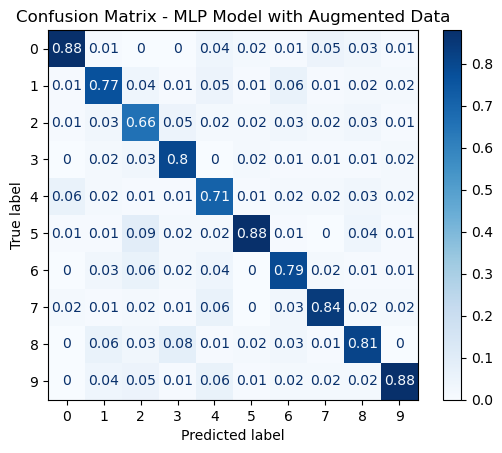

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten the train_images to match the shape of noisy_images_flattened
train_images_flattened = train_images.reshape(train_images.shape[0], -1)  # Reshape to (num_samples, 784)
# Combine augmented data with the original training data
x_train_augmented = np.concatenate((train_images_flattened, noisy_images_flattened))
y_train_augmented = np.concatenate((train_labels, noisy_labels))

# Preprocessing augmented dataset
x_train_augmented = x_train_augmented / 255.0
x_test_processed = test_images / 255.0

# Reshape the training and augmented data
x_train = train_images.reshape(-1, 28, 28, 1)  # Reshape to (samples, height, width, channels)
x_train_augmented = x_train_augmented.reshape(-1, 28, 28, 1)  # Do the same for augmented data
x_test_processed = x_test_processed.reshape(-1, 28, 28, 1)

# One-hot encode the train labels and noisy labels before concatenating
train_labels_one_hot = tf.one_hot(train_labels, depth=10)
noisy_labels_one_hot = tf.one_hot(noisy_labels, depth=10)
y_train_augmented = np.concatenate((train_labels_one_hot, noisy_labels_one_hot))

# Define the model
num_layers = 3
num_units = 512
learning_rate = 0.001
patience = 7

time_augmented_MLP = time.time()

model = Sequential([Flatten(input_shape=(28, 28))])
for _ in range(num_layers):
    model.add(Dense(num_units, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the data generator to the augmented training data
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator = datagen.flow(x_train_augmented, y_train_augmented, batch_size=64, seed=42)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# One-hot encode the test labels for validation (if not already done)
test_labels_one_hot = tf.one_hot(test_labels, depth=10)

# Train the model with augmented data
history = model.fit(train_generator, epochs=50, validation_data=(x_test_processed, test_labels_one_hot),
                    callbacks=[early_stopping], verbose=1)

# Evaluate the model
y_pred = model.predict(x_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_labels  # Keep y_true as integer labels for confusion matrix

log_time("Augmented MLP train time", time_augmented_MLP)

# Create and display the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_mean = np.sum(cm, axis=0)
cm = np.round(cm / cm_mean, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP Model with Augmented Data")
plt.show()


# Part 2

In [69]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Flatten images for input into the SAE
x_train = train_images.reshape(-1, 784)
x_test = test_images.reshape(-1, 784)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, train_labels, test_size=0.2, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)


In [70]:
num_classes = 10
bottleneck_dim = 10  # Bottleneck size

np.random.seed(42)
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


In [71]:
targets_tensor

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 0.19172212, -0.05336737,  0.24999535,  0.5878603 , -0.09037871,
        -0.09037237,  0.6095458 ,  0.2962151 , -0.1812081 ,  0.20941776],
       [-0.13733657, -0.13802177,  0.07170694, -0.5670119 , -0.5111896 ,
        -0.16663723, -0.30015847,  0.09312905, -0.26909828, -0.41854453],
       [ 0.5769192 , -0.0888717 ,  0.02658094, -0.5608196 , -0.21428385,
         0.04366215, -0.4530624 ,  0.14788496, -0.23642772, -0.1148186 ],
       [-0.16840775,  0.5184221 , -0.00377765, -0.29603583,  0.23021674,
        -0.341694  ,  0.05845748, -0.5484793 , -0.37173736,  0.05509821],
       [ 0.26208815,  0.06082008, -0.04104457, -0.1068643 , -0.52474016,
        -0.25547892, -0.16348466,  0.3751818 ,  0.12195309, -0.6257181 ],
       [ 0.1467472 , -0.1743676 , -0.3065144 ,  0.27697077,  0.4668429 ,
         0.42168933, -0.38000283, -0.14001325,  0.1499981 ,  0.4417328 ],
       [-0.18139906, -0.07028417, -0.41882077, -0.4528431 ,  0.30759

## Add new penalty layer

In [73]:
from tensorflow.keras.layers import Input, Dense, Layer

class PenaltyLayer(Layer):
    def __init__(self, targets, lambda_penalty, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        self.targets = targets
        self.lambda_penalty = lambda_penalty

    def call(self, bottleneck_outputs, labels):
        # Map labels to target vectors
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))

        # Compute penalty R
        squared_diff = tf.square(bottleneck_outputs - targets_batch)
        distances = tf.reduce_sum(squared_diff, axis=1)
        penalty_R = tf.reduce_mean(distances)

        # Add penalty to the model's total loss
        self.add_loss(self.lambda_penalty * penalty_R)
        return bottleneck_outputs


# Define SAE architecture
input_dim = 784  # Flattened input size
input_layer = Input(shape=(input_dim,))
encoder = Dense(800, activation='relu')(input_layer)
encoder = Dense(200, activation='relu')(encoder)
bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(encoder)

# Add Penalty Layer
labels_input = Input(shape=(num_classes,), name='labels')  # One-hot labels as input
penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty=0.1)(bottleneck, labels_input)

# Decoder
decoder = Dense(200, activation='relu')(penalty_layer)
decoder = Dense(800, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Create the full model
autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)



In [74]:

# Extract bottleneck model
bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)

def evaluate_R(x_data, y_data):
    bottleneck_outputs = bottleneck_model.predict(x_data)
    y_labels = np.argmax(y_data, axis=1)  # Convert one-hot to class labels
    targets_batch = tf.gather(targets_tensor, y_labels)
    squared_diff = tf.square(bottleneck_outputs - targets_batch)
    distances = tf.reduce_sum(squared_diff, axis=1)
    penalty_R = tf.reduce_mean(distances)
    return penalty_R.numpy()

# Evaluate R on training set
penalty_R_train = evaluate_R(x_train, y_train)
print(f"Penalty R on training set: {penalty_R_train:.4f}")






1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step
Penalty R on training set: 2.1230


## Train new penalty SAE with custom targets/direct assignment

In [76]:
# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(
    [x_train, y_train], x_train,
    validation_data=([x_val, y_val], x_val),
    epochs=30,
    batch_size=64,
    verbose=0
)

# Evaluate R after training
penalty_R_after = evaluate_R(x_train, y_train)
print(f"Penalty R after training: {penalty_R_after:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step
Penalty R after training: 0.0315


In [77]:
# Train SAE with custom targets
time_custom_target = time.time()
autoencoder_custom = Model(inputs=[input_layer, labels_input], outputs=output_layer)
autoencoder_custom.compile(optimizer='adam', loss='mse')
autoencoder_custom.fit([x_train, y_train], x_train, epochs=20, batch_size=64)

# Extract bottleneck outputs
latent_train_custom = bottleneck_model.predict(x_train)
latent_test_custom = bottleneck_model.predict(x_test)
log_time("Direct assignment training time", time_custom_target)
newsae_custom_total_params = autoencoder.count_params()
print(f"Total parameters in new SAE model with custom targets: {newsae_custom_total_params}")

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0460
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0454
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0453
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0451
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0450
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0448
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0446
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0449
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0453
Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0448
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0443
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0441
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0438
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0437
Epoch 15/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

In [78]:
# Train SAE with direct assignments
time_direct_assignment = time.time()
direct_targets_tensor = tf.convert_to_tensor(np.eye(num_classes), dtype=tf.float32)
penalty_layer_direct = PenaltyLayer(direct_targets_tensor, lambda_penalty=0.1)(bottleneck, labels_input)

decoder = Dense(200, activation='relu')(penalty_layer_direct)
decoder = Dense(800, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder_direct = Model(inputs=[input_layer, labels_input], outputs=output_layer)
autoencoder_direct.compile(optimizer='adam', loss='mse')
autoencoder_direct.fit([x_train, y_train], x_train, epochs=20, batch_size=64)

# Extract bottleneck outputs
latent_train_direct = bottleneck_model.predict(x_train)
latent_test_direct = bottleneck_model.predict(x_test)
log_time("Direct assignment training time", time_direct_assignment)
newsae_direct_total_params = autoencoder.count_params()
print(f"Total parameters in new SAE model with direct assignment: {sae_total_params}")

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1400
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0738
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0642
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0591
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0560
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0541
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0526
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0516
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0507
Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0499
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0492
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0486
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0481
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0478
Epoch 15/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lo

In [79]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Custom targets
svm_custom = SVC(kernel='linear', C=1.0)
svm_custom.fit(latent_train_custom, np.argmax(y_train, axis=1))
train_acc_custom = svm_custom.score(latent_train_custom, np.argmax(y_train, axis=1))
test_acc_custom = svm_custom.score(latent_test_custom, np.argmax(y_test, axis=1))

print(f"SVM Accuracy (Custom Targets - Train): {train_acc_custom:.4f}")
print(f"SVM Accuracy (Custom Targets - Test): {test_acc_custom:.4f}")

# Direct assignments
svm_direct = SVC(kernel='linear', C=1.0)
svm_direct.fit(latent_train_direct, np.argmax(y_train, axis=1))
train_acc_direct = svm_direct.score(latent_train_direct, np.argmax(y_train, axis=1))
test_acc_direct = svm_direct.score(latent_test_direct, np.argmax(y_test, axis=1))

print(f"SVM Accuracy (Direct Assignments - Train): {train_acc_direct:.4f}")
print(f"SVM Accuracy (Direct Assignments - Test): {test_acc_direct:.4f}")


SVM Accuracy (Custom Targets - Train): 0.9973
SVM Accuracy (Custom Targets - Test): 0.8982
SVM Accuracy (Direct Assignments - Train): 0.9980
SVM Accuracy (Direct Assignments - Test): 0.8835


In [80]:
def generate_target_sets(num_classes, bottleneck_dim, num_sets):
    target_sets = []
    for _ in range(num_sets):
        targets = np.random.randn(num_classes, bottleneck_dim)
        targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
        target_sets.append(tf.convert_to_tensor(targets, dtype=tf.float32))
    return target_sets

# Generate 5 different target sets
num_target_sets = 3
target_sets = generate_target_sets(num_classes=10, bottleneck_dim=10, num_sets=num_target_sets)


## Grid search lambda and R

In [82]:
# Define lambda values
lambda_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8]

# Results storage
results_3d = []

for target_index, targets_tensor in enumerate(target_sets):
    for lambda_penalty in lambda_values:
        time_newsae_grid = time.time()
        print(f"\nTraining with Target Set {target_index + 1}, Lambda={lambda_penalty}...")

        # Rebuild SAE with the current target set and lambda
        penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty=lambda_penalty)(bottleneck, labels_input)
        decoder = Dense(200, activation='relu')(penalty_layer)
        decoder = Dense(800, activation='relu')(decoder)
        output_layer = Dense(input_dim, activation='sigmoid')(decoder)
        autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
        autoencoder.compile(optimizer='adam', loss='mse')

        # Train SAE
        autoencoder.fit([x_train, y_train], x_train, epochs=25, batch_size=64, verbose=0,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

        # Evaluate penalty R on validation set
        penalty_R = evaluate_R(x_val, y_val)

        # Evaluate SVM accuracy on validation set
        latent_val = bottleneck_model.predict(x_val)
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(latent_val, np.argmax(y_val, axis=1))
        val_acc = svm.score(latent_val, np.argmax(y_val, axis=1))

        # Store results
        results_3d.append({'target_set': target_index + 1, 'lambda': lambda_penalty,
                           'penalty_R': penalty_R, 'accuracy': val_acc})
        log_time("Training time",time_newsae_grid)
        print(f"Penalty R: {penalty_R:.4f}, Accuracy: {val_acc:.4f}")




Training with Target Set 1, Lambda=0.001...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
Training time completed in 80.57 seconds.
Penalty R: 0.9235, Accuracy: 0.8362

Training with Target Set 1, Lambda=0.01...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
Training time completed in 77.90 seconds.
Penalty R: 0.2711, Accuracy: 0.9188

Training with Target Set 1, Lambda=0.1...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
Training time completed in 82.81 seconds.
Penalty R: 0.1232, Accuracy: 0.9541

Training with Target Set 1, Lambda=0.2...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
Training time completed in 77.82 seconds.
Penalty R: 0.1173, Accuracy: 0.9536

Training with Target Set 1, Lambda=0.4...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
Training time completed in 80.95 seconds.
Penalty R: 0.1089, Accuracy: 0.9535

Training with Target Set 1, Lambda=0.8...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
Training time completed in 80.43 seconds.
Penalty R: 0.1069, Accuracy: 0.9551

Training with Target Set 2, Lambda=0.001...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
Training time completed in 83.84 seconds.
Penalty R: 0.8163, Accuracy: 0.8347

Training with Target Set 2, Lambda=0.01...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
Training time completed in 81.19 seconds.
Penalty R: 0.2662, Accuracy: 0.9222

Training with Target Set 2, Lambda=0.1...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
Training time completed in 82.11 seconds.
Penalty R: 0.1401, Accuracy: 0.9404

Training with Target Set 2, Lambda=0.2...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
Training time completed in 80.12 seconds.
Penalty R: 0.1466, Accuracy: 0.9327

Training with Target Set 2, Lambda=0.4...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
Training time completed in 78.82 seconds.
Penalty R: 0.1643, Accuracy: 0.9285

Training with Target Set 2, Lambda=0.8...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Training time completed in 78.60 seconds.
Penalty R: 0.1802, Accuracy: 0.9247

Training with Target Set 3, Lambda=0.001...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
Training time completed in 83.34 seconds.
Penalty R: 0.8502, Accuracy: 0.8373

Training with Target Set 3, Lambda=0.01...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
Training time completed in 79.31 seconds.
Penalty R: 0.2984, Accuracy: 0.9086

Training with Target Set 3, Lambda=0.1...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
Training time completed in 78.37 seconds.
Penalty R: 0.1433, Accuracy: 0.9388

Training with Target Set 3, Lambda=0.2...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
Training time completed in 76.99 seconds.
Penalty R: 0.1408, Accuracy: 0.9307

Training with Target Set 3, Lambda=0.4...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
Training time completed in 76.67 seconds.
Penalty R: 0.1440, Accuracy: 0.9248

Training with Target Set 3, Lambda=0.8...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_170', 'labels']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
Training time completed in 78.60 seconds.
Penalty R: 0.1474, Accuracy: 0.9217


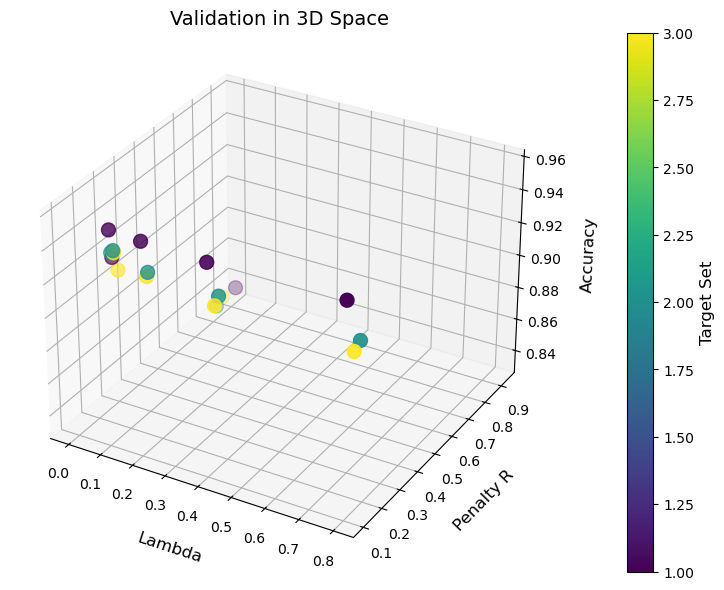

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


results_df = pd.DataFrame(results_3d)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    results_df['lambda'], results_df['penalty_R'], results_df['accuracy'],
    c=results_df['target_set'], cmap='viridis', s=100
)

# Add a color bar for target sets
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Target Set', fontsize=12)

# Set labels and title
ax.set_xlabel('Lambda', labelpad=10, fontsize=12)
ax.set_ylabel('Penalty R', labelpad=10, fontsize=12)
ax.set_zlabel('Accuracy', labelpad=10, fontsize=12)
ax.set_title('Validation in 3D Space', fontsize=14)

# Adjust tick label sizes
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)

# Add a grid for better reference
ax.grid(True)

# Show the plot
plt.show()




## SAE with new penalty on augmented data

In [85]:
class PenaltyLayer(tf.keras.layers.Layer):
    def __init__(self, targets, lambda_penalty):
        super(PenaltyLayer, self).__init__()
        # Ensure targets are of float32 type
        self.targets = tf.cast(targets, tf.float32)
        self.lambda_penalty = lambda_penalty

    def call(self, bottleneck_outputs, labels):
        # Ensure both bottleneck outputs and labels are of the same dtype (float32)
        bottleneck_outputs = tf.cast(bottleneck_outputs, tf.float32)
        labels = tf.cast(labels, tf.float32)

        # Select the target for each sample based on the labels (one-hot encoded)
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))

        # Ensure the target batch is the same type as bottleneck_outputs
        targets_batch = tf.cast(targets_batch, tf.float32)

        # Compute squared differences between bottleneck outputs and targets
        squared_diff = tf.square(bottleneck_outputs - targets_batch)
        distances = tf.reduce_sum(squared_diff, axis=1)

        # Compute penalty and add it to the total loss
        penalty_R = self.lambda_penalty * tf.reduce_mean(distances)
        self.add_loss(penalty_R)
        
        # Return the bottleneck layer outputs unchanged
        return bottleneck_outputs

# Define lambda values
lambda_penalty = 0.4

# Print info for current setup
time_newsae_augmented = time.time()
print(f"\nTraining with augmented set, Lambda={lambda_penalty}...")

# Build the SAE model with the custom penalty layer
input_dim = 784  # Flattened MNIST image size (28x28)
bottleneck_size = 64
targets_tensor = np.random.randn(10, bottleneck_size).astype(np.float32)  # Example targets for each class (random for now)
labels_input = Input(shape=(10,))  # One-hot encoded labels input
input_layer = Input(shape=(28, 28, 1))  # Input layer for MNIST images

# Flatten and process the image input
flattened = tf.keras.layers.Flatten()(input_layer)
bottleneck = Dense(bottleneck_size, activation='sigmoid')(flattened)

# Apply the penalty layer
penalty_layer = PenaltyLayer(targets=targets_tensor, lambda_penalty=lambda_penalty)(bottleneck, labels_input)

from tensorflow.keras.layers import Lambda

# Decoder part of the autoencoder (no need to flatten the output)
decoder = Dense(200, activation='relu')(penalty_layer)
decoder = Dense(800, activation='relu')(decoder)
output_layer = Dense(28 * 28, activation='sigmoid')(decoder)  # Output layer matches input dimensions (28x28)

# Reshape the output to (batch_size, 28, 28, 1) using a Lambda layer
output_layer = Lambda(lambda x: tf.reshape(x, (-1, 28, 28, 1)))(output_layer)

# Define and compile the autoencoder
autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Define the bottleneck model (for extracting the latent space)
bottleneck_model = Model(inputs=input_layer, outputs=bottleneck)

# Ensure that x_train_augmented and y_train_augmented are in the correct shape (28, 28, 1)
x_train_augmented = x_train_augmented.reshape(-1, 28, 28, 1) 
x_val = x_val.reshape(-1, 28, 28, 1) 

# Train SAE on the augmented dataset
autoencoder.fit([x_train_augmented, y_train_augmented], x_train_augmented, epochs=25, batch_size=64, verbose=0,
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# Evaluate penalty R on validation set
penalty_R = evaluate_R(x_val, y_val) 

# Extract latent space features from bottleneck model
latent_val = bottleneck_model.predict(x_val)

# Train and evaluate SVM
svm = SVC(kernel='linear', C=1.0)
svm.fit(latent_val, np.argmax(y_val, axis=1))
val_acc = svm.score(latent_val, np.argmax(y_val, axis=1))

# Log time and print results
log_time("Training time of new SAE on augmented data", time_newsae_augmented)
print(f"Penalty R: {penalty_R:.4f}, Accuracy: {val_acc:.4f}")

# Get total number of parameters in the new SAE model
aug_newsae_total_params = autoencoder.count_params()
print(f"Total parameters in new SAE model on augmented data: {aug_newsae_total_params}")



Training with augmented set, Lambda=0.4...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_255', 'keras_tensor_254']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
Training time of new SAE on augmented data completed in 60.06 seconds.
Penalty R: 57.7582, Accuracy: 0.8012
Total parameters in new SAE model on augmented data: 852024


## MLP with new penalty on augmented data

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_265', 'keras_tensor_266']. Received: the structure of inputs=('*', '*')
  warnings.warn(


954/954 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1063 - loss: 31.7718 - val_accuracy: 0.2175 - val_loss: 27.0053
Epoch 2/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3497 - loss: 27.1310 - val_accuracy: 0.3842 - val_loss: 26.8133
Epoch 3/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5771 - loss: 25.5321 - val_accuracy: 0.4223 - val_loss: 26.9544
Epoch 4/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6648 - loss: 24.8250 - val_accuracy: 0.5199 - val_loss: 26.9294
Epoch 5/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7452 - loss: 24.3719 - val_accuracy: 0.5575 - val_loss: 26.9480
Epoch 6/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7677 - loss: 24.1300 - val_accuracy: 0.5742 - val_loss: 26.7743
Epoch 7/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7798 - loss: 23.9617 - val_accuracy: 0.5883 - val_loss: 26.4727
Epoch 8/50
954/954 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7903 - loss: 23.8209 - val_accuracy

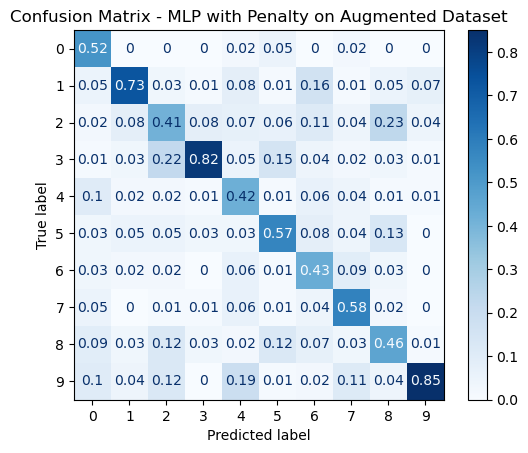

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the PenaltyLayer class as before
class PenaltyLayer(tf.keras.layers.Layer):
    def __init__(self, targets, lambda_penalty, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        self.targets = targets
        self.lambda_penalty = lambda_penalty

    def call(self, bottleneck_outputs, labels):
        # Map labels to target vectors
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))
        targets_batch = tf.cast(targets_batch, tf.float32)

        # Compute penalty R
        squared_diff = tf.square(bottleneck_outputs - targets_batch)
        distances = tf.reduce_sum(squared_diff, axis=1)
        penalty_R = tf.reduce_mean(distances)

        # Add penalty to the model's total loss
        self.add_loss(self.lambda_penalty * penalty_R)
        return bottleneck_outputs

# Define the MLP model
def create_mlp_model(input_dim, bottleneck_size, targets_tensor, lambda_penalty):
    input_layer = Input(shape=(28, 28))  # MNIST input size (28x28)
    labels_input = Input(shape=(10,))  # One-hot encoded labels
    
    # Flatten and process the input
    flattened = Flatten()(input_layer)
    
    # MLP layers
    bottleneck = Dense(bottleneck_size, activation='sigmoid')(flattened)
    
    # Apply penalty layer
    penalty_layer = PenaltyLayer(targets=targets_tensor, lambda_penalty=lambda_penalty)(bottleneck, labels_input)

    # Decoder part of the MLP
    decoder = Dense(512, activation='relu')(penalty_layer)
    decoder = Dense(256, activation='relu')(decoder)
    output_layer = Dense(10, activation='softmax')(decoder)

    # Define and compile the model
    model = Model(inputs=[input_layer, labels_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define lambda_penalty and targets for penalty
lambda_penalty = 0.4
bottleneck_size = 64
targets_tensor = np.random.randn(10, bottleneck_size)  # Example random targets for each class (can be pre-defined)
time_newMLP_augmented = time.time()

# Create and train the MLP model on the augmented dataset
model = create_mlp_model(input_dim=784, bottleneck_size=bottleneck_size, targets_tensor=targets_tensor, lambda_penalty=lambda_penalty)

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the MLP with augmented dataset
history = model.fit([x_train_augmented, y_train_augmented], y_train_augmented, 
                    epochs=50, batch_size=64, validation_data=([x_val, y_val], y_val), 
                    callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
x_test_reshaped = x_test.reshape(-1, 28, 28)
x_val_reshaped = x_val.reshape(-1, 28, 28)
y_pred = model.predict([x_test_reshaped, y_test])
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # True labels

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_true, y_pred_classes)
log_time("Training time of new MLP on augmented data", time_newMLP_augmented)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_mean = np.sum(cm, axis=0)
cm = np.round(cm / cm_mean, 2)  # Normalize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP with Penalty on Augmented Dataset")
plt.show()
